In [1]:
# If You use in Colab, You Should run this script
import os
if (not os.path.exists("./SSD-object-detection") and
    not "SSD-object-detection" in os.getcwd()):
    !git clone https://github.com/pai-sj/SSD-object-detection.git
    os.chdir("./SSD-object-detection")

In [2]:
%matplotlib inline

import sys
sys.path.append("../")
from utils import DetectionDataset, draw_rectangle
from models.generator import DetectionGenerator, PriorBoxes
from models.ssd import build_base_network, attach_multibox_head
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

np.random.seed(10)
tf.random.set_random_seed(10)

# \[ 모델 학습 \]
----
----

우리는 학습할 모델과 데이터를 이전 시간에서 꾸렸습니다. 이제 학습까지 남은 것은 모델을 어떻게 학습시킬까?입니다. 이 중 제일 핵심은 바로 Loss함수 설계에 있습니다.

## 1. Loss 계산하기
----

원문에 있는 설명을 가져왔습니다. 우리가 학습해야 하는 것은 위치를 추론하는 Regressor와 사물을 분류하는 Classifer입니다. Regressor의 경우에는 SmoothL1이라 불리는 Loss로 학습을 시키고, Classifier은 분류모델에서 주로 사용하는 Cross-Entropy Loss를 이용합니다. Regressor의 경우에는 당연하게도 Matched prior box의 경우 한에서만 학습을 해야 합니다. SmoothL1은 MAE와 MSE의 합쳐놓은 형태로, 수식은 아래와 같습니다.

$
smooth_{L1}(x) = \begin{cases}
0.5x^2, \mbox{  if  } |x| <1\\
|x| - 0.5 \mbox{   otherwise,}
\end{cases}
$

The SSD Training Objective is derived from the MultiBox Objective, but is extended to handle multiple object categories. Let $x^p_{ij}= {1,0}$ be an indicator for matching the i-th default box to the j-th ground truth box of category $p$. In the matching strategy above, we can have $\sum_i x^{p}_{ij} \ge 1$. The overall objective loss function is a weighted sum of the localization loss(loc) and the confidence loss(conf):

$
L(x,c,l,g)= \frac{1}{N}(L_{conf}(x,c)+\alpha L_{loc}(x,l,g)) 
$

Where N is the number of matched default boxes. if $N = 0$, we set the loss to 0. The localization loss is a Smooth L1 
loss between the predicted box(l) and the ground truth box(g) parameters. Similar to Faster R-CNN, we regress to offsets for the center$(cx,cy)$ of the default bounding box(p) and for its width(w) and height (h).<br>

$
L_{loc}(x,l,g) = \sum^{N}_{i\in Pos} \sum_{m \in {cx,cy,w,h}} x_{ij}^k smooth_{L1}(l^m_i-\hat g^m_j) \\
\hat g^{cx} = \frac{(g^{cx} - p^{cx})}{p^{w}}, \hat g^{cy} = \frac{(g^{cy} - p^{cy})}{p^{h}}\\  
\hat g^{w} = log(\frac{g^{w}}{p^{w}}), \hat g^{h} = log(\frac{g^{h}}{p^{h}}) \\
$<br>
The confidence loss is the softmax loss over multiple classes confidences (c).<br>
$
L_{conf}(x,c) = - \sum^{N}_{i\in Pos} x^{P}_{ij}log(\hat c^p_i) - \sum^{N}_{i\in Neg} log(\hat c_i^p) where \hat c^p_i = \frac{exp(c_i^p)}{\sum_p exp(c^p_i)}
$<br>

Confidence Loss를 계산할 때, 중요한 문제가 하나 있습니다. 바로 Class Imbalance 문제입니다. 영상에서 대부분은 BackGround에 해당합니다. 우리가 원하는 Foreground에 매칭된 Prior box는 극히 일부분에 불과합니다. 이 때문에, Easy Negative Sample, 즉 Background에 대한 Loss가 지나치게 커서, 실제로 학습하고자 하는 Foreground에 대한 학습은 잘 이루어지지 않게 됩니다. 이를 방지하기 위해, Negative Sample 중 가장 Loss가 큰것들을 위주로만 추출하여 학습하도록 합니다.

In [3]:
def SSDLoss(alpha=1., pos_neg_ratio=3.):
    def ssd_loss(y_true, y_pred):
        num_classes = tf.shape(y_true)[2] - 4
        y_true = tf.reshape(y_true, [-1, num_classes + 4])
        y_pred = tf.reshape(y_pred, [-1, num_classes + 4])
        eps = K.epsilon()

        # Split Classification and Localization output
        y_true_clf, y_true_loc = tf.split(y_true, 
                                          [num_classes, 4], 
                                          axis=-1)
        y_pred_clf, y_pred_loc = tf.split(y_pred, 
                                          [num_classes, 4], 
                                          axis=-1)

        # split foreground & background
        neg_mask = y_true_clf[:, -1]
        pos_mask = 1 - neg_mask
        num_pos = tf.reduce_sum(pos_mask)
        num_neg = tf.reduce_sum(neg_mask)
        num_neg = tf.minimum(pos_neg_ratio * num_pos, num_neg)

        # softmax loss
        y_pred_clf = K.clip(y_pred_clf, eps, 1. - eps)
        clf_loss = -tf.reduce_sum(y_true_clf * tf.log(y_pred_clf),
                                  axis=-1)
        pos_clf_loss = tf.reduce_sum(clf_loss * pos_mask) / (num_pos + eps)
        neg_clf_loss = clf_loss * neg_mask
        values, indices = tf.nn.top_k(neg_clf_loss,
                                      k=tf.cast(num_neg, tf.int32))
        neg_clf_loss = tf.reduce_sum(values) / (num_neg + eps)
        clf_loss = pos_clf_loss + neg_clf_loss
        
        # smooth l1 loss
        l1_loss = tf.abs(y_true_loc - y_pred_loc)
        l2_loss = 0.5 * (y_true_loc - y_pred_loc) ** 2
        loc_loss = tf.where(tf.less(l1_loss, 1.0),
                            l2_loss,
                            l1_loss - 0.5)
        loc_loss = tf.reduce_sum(loc_loss, axis=-1)
        loc_loss = tf.reduce_sum(loc_loss * pos_mask) / (num_pos + eps)

        # total loss
        return clf_loss + alpha * loc_loss
    return ssd_loss

## 2. 모델 구성하기
---


In [4]:
strides = [4, 8, 16]
scales = [10, 25, 40]
ratios = [(1,1),     # ratio : 1.
          (0.5,1.5), # ratio : 0.33
          (0.8,1.2), # ratio : 0.67
          (1.2,0.8), # ratio : 1.5
          (1.4,1.4)]

prior = PriorBoxes(strides,scales,ratios)

In [5]:
base_network = build_base_network(num_units=16)
predictions = attach_multibox_head(base_network,
                                   ['norm3_2','norm4_2','norm5_2'],
                                   num_priors=len(ratios))
model = Model(base_network.input,
              predictions,
              name='ssd')

W0730 10:04:45.216184 4497679808 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 3. 데이터 구성하기
---


In [6]:
trainset = DetectionDataset(data_type='train')
validset = DetectionDataset(data_type='validation')

# .config로 했을 때에만 use_multiprocessing이 가능함
# Argument로 들어가는 것들이 Serialize되는 Class이어야 되기 때문
traingen = DetectionGenerator(trainset.config, 
                              prior.config, 
                              batch_size=64)
validgen = DetectionGenerator(validset.config, 
                              prior.config, 
                              batch_size=64)

## 4. 모델 컴파일 및 학습하기
----


In [7]:
from models.losses import SSDLoss
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [8]:
model.compile(Adam(1e-3),
              loss=SSDLoss(1.0,3.))

callbacks =[]
rlrop = ReduceLROnPlateau(factor=0.1, 
                          min_lr=1e-6, 
                          patience=5,
                          cooldown=3)
callbacks.append(rlrop)

W0730 10:04:59.756595 4497679808 deprecation_wrapper.py:119] From ../models/losses.py:48: The name tf.log is deprecated. Please use tf.math.log instead.

W0730 10:04:59.778692 4497679808 deprecation.py:323] From ../models/losses.py:62: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.fit_generator(traingen,
                    epochs=50,
                    validation_data=validgen,
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=callbacks)

## 5. 모델을 통해 예측하기
----

모델을 학습시키는 데에 시간이 걸리므로, 우선 학습된 모델을 이용해보도록 하겠습니다.

In [10]:
from tensorflow.keras.models import load_model

model = load_model("../samples/pretrained_ssd.h5",
                   custom_objects={'ssd_loss':SSDLoss(1.0,3.)})

### (1) 출력값을 predicted Bounding Box로 변경하기

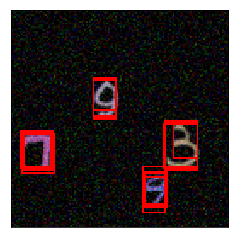

In [23]:
images, _ = validgen[0] # 이미지를 가져오기
predictions = model.predict(images)

idx=0
pred_loc = predictions[idx,:,-4:]
pred_clf = predictions[idx,:,:-4]
pr_boxes = prior.generate(images[0].shape)

# 원래의 bounding box로 복원하기
res_cx = (pred_loc[:,0] 
          * pr_boxes[:,2] 
          + pr_boxes[:,0])
res_cy = (pred_loc[:,1] 
          * pr_boxes[:,3] 
          + pr_boxes[:,1])
res_w = (np.exp(pred_loc[:,2])
         *pr_boxes[:,2])
res_h = (np.exp(pred_loc[:,3])
         *pr_boxes[:,3])

restore_boxes = np.stack([res_cx,res_cy,res_w,res_h],
                         axis=-1)

# Background를 제외
bg_index = pred_clf.shape[-1]-1
fg_indices = np.argwhere(pred_clf.argmax(axis=1)!=bg_index)
restore_boxes = restore_boxes[fg_indices].squeeze()

pred_clf = pred_clf[fg_indices]
pred_clf = pred_clf.max(axis=-1)
pred_clf = pred_clf.squeeze()

vis = draw_rectangle(images[idx],restore_boxes)
plt.imshow(vis)
plt.xticks([])
plt.yticks([])    
plt.show()        

위의 경우 너무나 겹치는 이미지들이 많습니다. 이를 어떻게 효과적으로 겹치는 것들을 지울 수 있을까요? 바로 그 알고리즘이 `Non-Maximum Suppression` 입니다.

### (2) Non-Maximum Suppression 적용하기

Non-Maximum Suppression의 알고리즘은 심플합니다. 하나씩 박스를 꺼내서 해당 박스와 특정값 이상(예 50% 이상) 겹치면 제거해주는 알고리즘입니다. 

![Imgur](https://i.imgur.com/NsppxPr.png)

In [42]:
def non_maximum_suppression(boxes, confs, overlap_threshold=0.3):
    pick = []
    cx, cy, w, h = boxes.T
    x1, x2 = cx - w/2, cx + w/2
    y1, y2 = cy - h/2, cy + h/2    
    
    indices = np.argsort(confs)[::-1]
    area = (x2 - x1) * (y2 - y1)
    
    while len(indices) > 1:
        idx, indices = indices[0], indices[1:]
        pick.append(idx)

        xx1 = np.maximum(x1[idx], x1[indices])
        yy1 = np.maximum(y1[idx], y1[indices])
        xx2 = np.minimum(x2[idx], x2[indices])
        yy2 = np.minimum(y2[idx], y2[indices])
        
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        
        intersection = w * h
        union = area[indices] + area[idx] - intersection
        overlap = intersection/(union+1e-8)
        
        indices = indices[overlap <= overlap_threshold]
    return pick

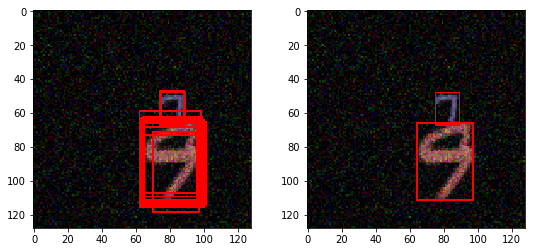

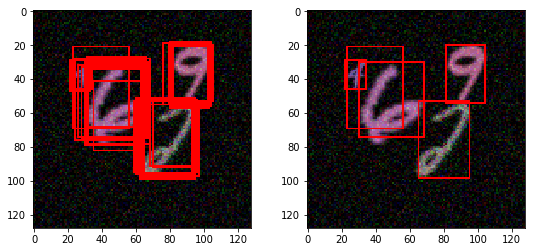

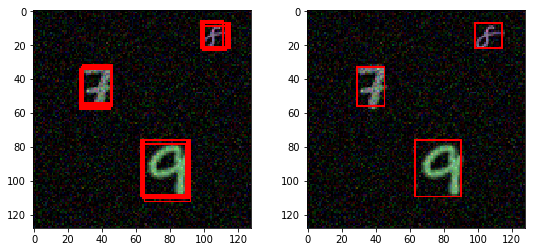

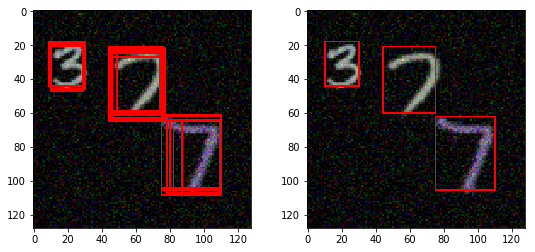

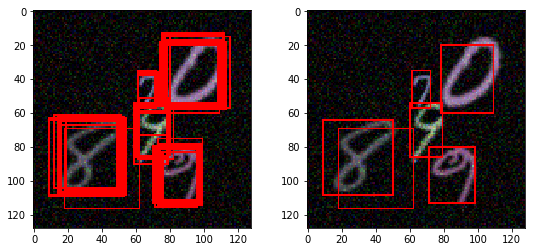

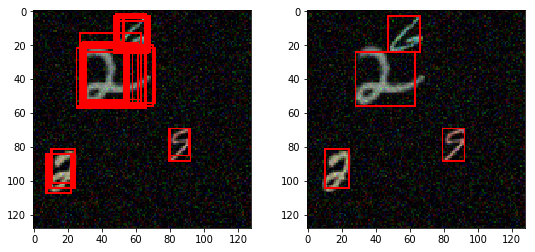

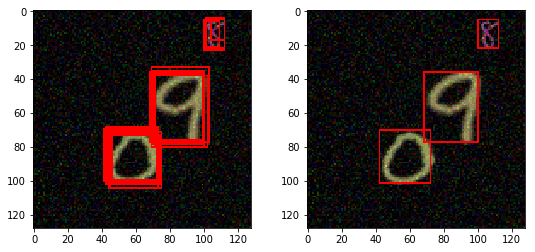

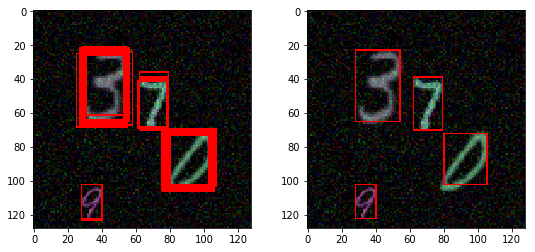

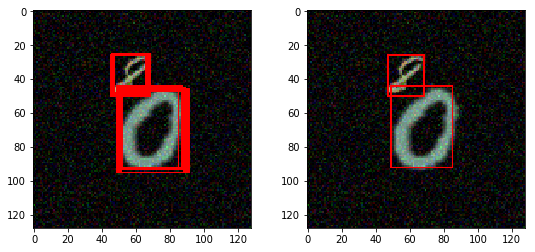

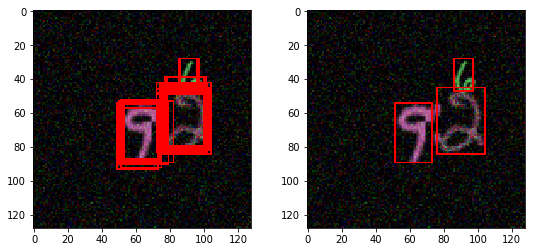

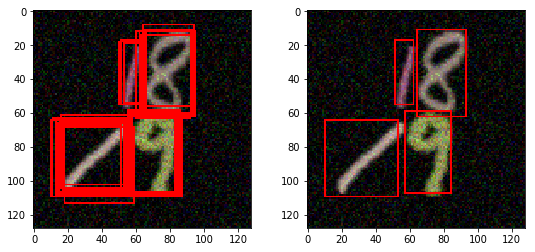

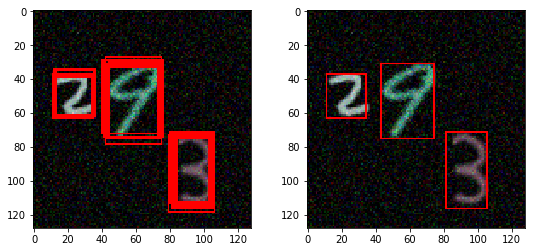

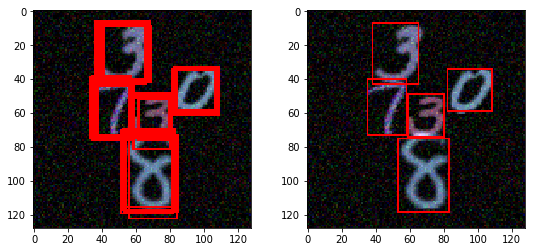

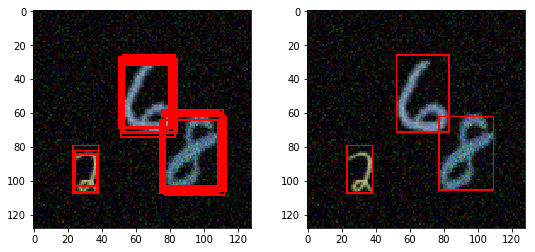

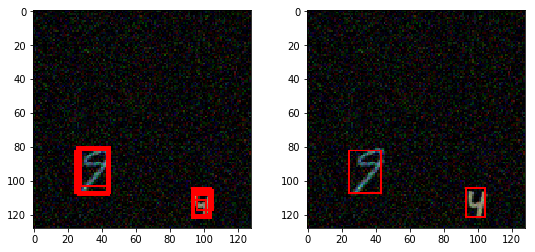

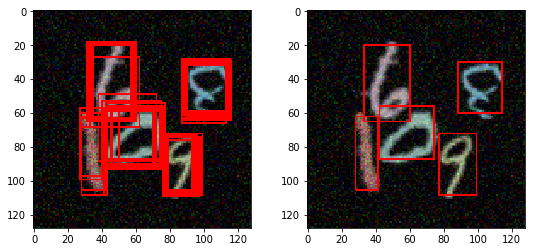

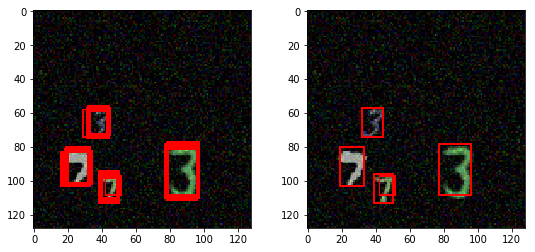

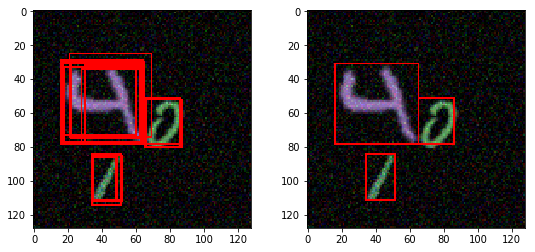

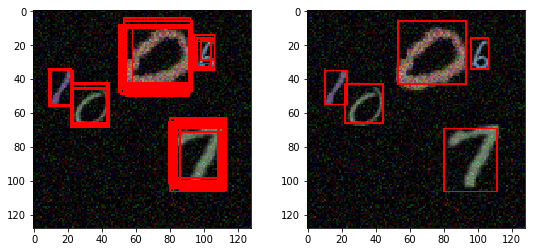

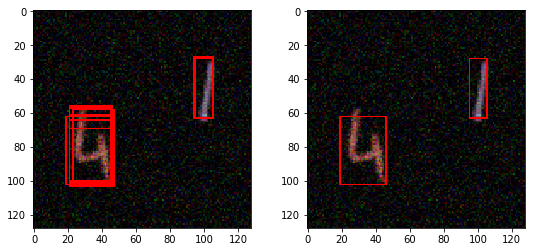

In [43]:
images, labels = validgen[0]
predictions = model.predict(images)

for idx, image in enumerate(images[:20]):
    pred_loc = predictions[idx,:,-4:]
    pred_clf = predictions[idx,:,:-4]
    pr_boxes = prior.generate(images[0].shape)

    # 예측값을 bounding Box 값(cx,cy,w,h)으로 복원하기
    res_cx = (pred_loc[:,0] 
              * pr_boxes[:,2] 
              + pr_boxes[:,0])
    res_cy = (pred_loc[:,1] 
              * pr_boxes[:,3] 
              + pr_boxes[:,1])
    res_w = (np.exp(pred_loc[:,2])
             *pr_boxes[:,2])
    res_h = (np.exp(pred_loc[:,3])
             *pr_boxes[:,3])
    restore_boxes = np.stack([res_cx,res_cy,res_w,res_h],
                             axis=-1)
    
    bg_index = pred_clf.shape[-1]-1
    fg_indices = np.argwhere(pred_clf.argmax(axis=1)!=bg_index)
    
    restore_boxes = restore_boxes[fg_indices].squeeze()
    pred_clf = pred_clf[fg_indices]
    pred_clf = pred_clf.max(axis=-1)
    pred_clf = pred_clf.squeeze()
    
    before_nms = draw_rectangle(images[idx], restore_boxes)

    # NMS 적용
    pick_indices = non_maximum_suppression(restore_boxes, pred_clf, 0.5)
    chosen = restore_boxes[pick_indices]
    after_nms = draw_rectangle(images[idx], chosen)
    
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(before_nms)
    ax = fig.add_subplot(1,2,2)
    ax.imshow(after_nms)
    plt.show()
    
    